# Problem 1

## 导入包

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## 读取并处理数据

In [2]:
# 读取数据
df = pd.read_csv("./heart_500.csv")
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values
# 将特征进行标准化
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [3]:
# 描述性统计
df.describe()

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.00000,500.00000,500.000000,500.000000,500.000000,500.000000
mean,0.084000,0.384000,0.438000,0.950000,28.560000,0.410000,0.036000,0.264000,0.756000,0.616000,...,0.938000,0.074000,2.412000,3.016000,3.86600,0.15200,0.478000,7.838000,5.150000,6.276000
std,0.277666,0.486845,0.496638,0.218163,6.701658,0.492326,0.186477,0.671719,0.429923,0.486845,...,0.241397,0.262033,1.037501,7.400086,8.03325,0.35938,0.500016,2.916293,0.936619,2.018905
min,0.000000,0.000000,0.000000,0.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.00000,0.00000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,2.000000,0.000000,0.00000,0.00000,0.000000,6.000000,4.000000,5.000000
50%,0.000000,0.000000,0.000000,1.000000,27.500000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,2.000000,0.000000,0.00000,0.00000,0.000000,8.000000,5.000000,7.000000
75%,0.000000,1.000000,1.000000,1.000000,31.250000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,3.000000,1.000000,3.00000,0.00000,1.000000,10.000000,6.000000,8.000000
max,1.000000,1.000000,1.000000,1.000000,84.000000,1.000000,1.000000,2.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,30.000000,30.00000,1.00000,1.000000,13.000000,6.000000,8.000000


/var/folders/42/jyhy15vj39n097qrn_qd65940000gn/T/ipykernel_56720/4101752837.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist(ax=plt.figure(figsize=(16, 12)).gca())


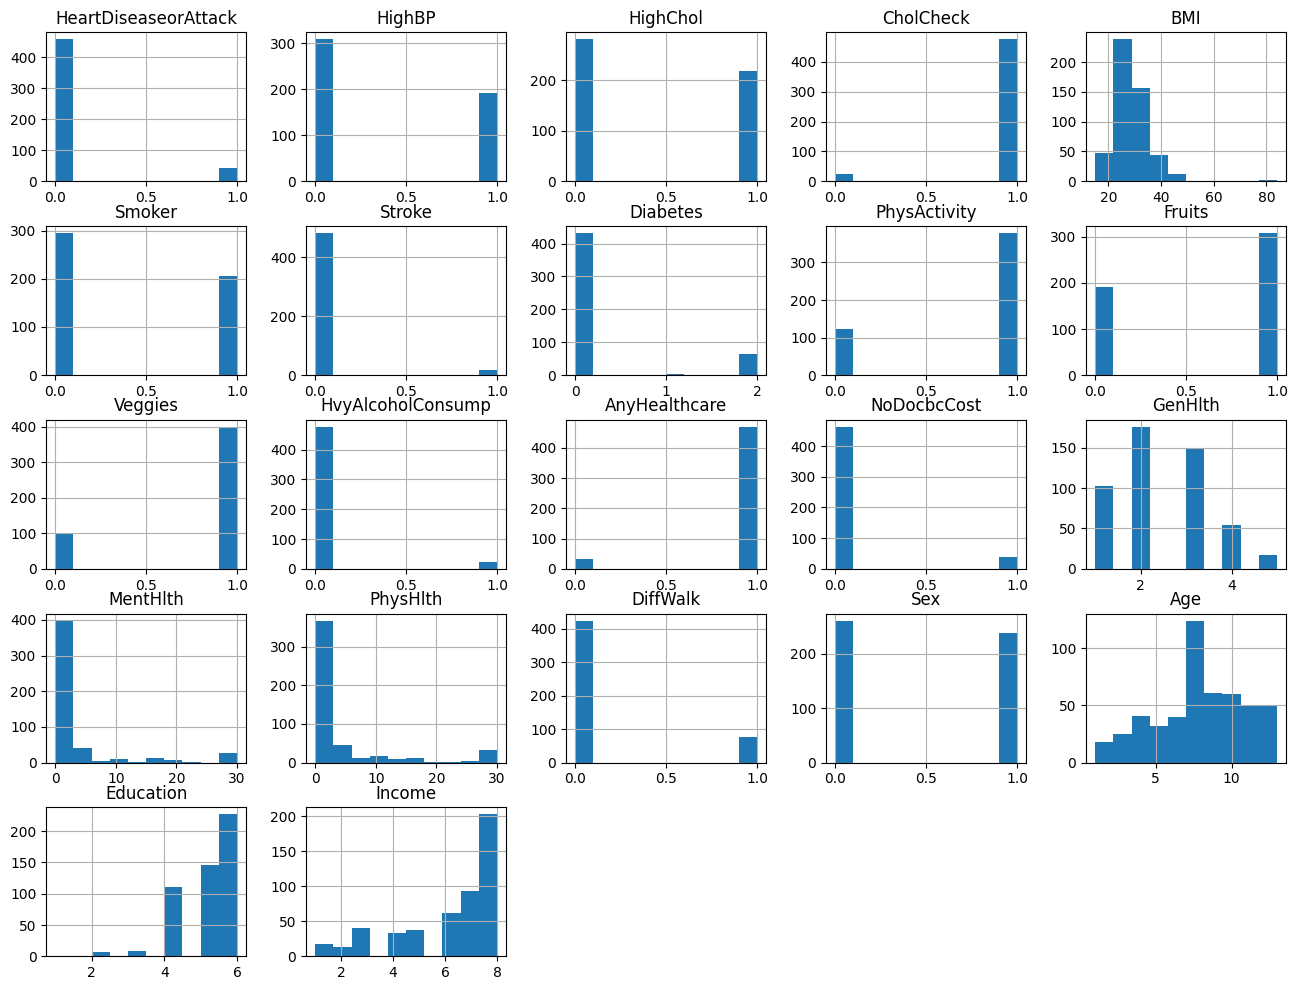

In [4]:
# 绘制直方图
df.hist(ax=plt.figure(figsize=(16, 12)).gca())
# 显示图形
plt.show()

## 谱聚类

此处选用高斯相似度函数对样本之间的欧式距离进行变换，作为相似度矩阵的输入。主要原因是：

1. 特征经过标准化后，各个特征的量纲一致，可以直接计算欧式距离，以衡量样本之间的相似和差异。欧式距离越小，说明样本越相似。
2. 高斯相似度函数的形式为：$w_{ij} = exp(-\frac{||x_i-x_j||^2}{2\sigma^2})$，其中$\sigma$为高斯核的带宽。它可以将欧式距离转换为相似度，且相似度的取值范围为[0,1]，其值越大表示样本越相似。
3. 由原始数据的描述性统计和直方图可以看出，特征中有大量类别型变量，即取值只可能为 0 或 1。这可能导致大量样本在某些变量上的取值相同，从而导致在应用 K 近邻方法时，K 值选取不当会导致聚类结果不稳健。
4. 这种方法考虑了每个样本与其他所有样本之间的距离，即有效利用了所有样本的信息，结果可能更加准确和稳健。

In [3]:
# 计算各个样本之间的欧式距离
dist = cdist(X, X)
# 使用高斯相似度函数计算 similarity graph
sigma = 10
w = np.exp(-np.power(dist, 2) / (2 * np.power(sigma, 2)))
# 使用谱聚类进行聚类
clustering = SpectralClustering(
    n_clusters=2,
    random_state=0,
    affinity="precomputed",
    assign_labels="kmeans",
)
clustering.fit(w)

SpectralClustering(affinity='precomputed', n_clusters=2, random_state=0)

## 评估聚类效果

In [4]:
# 计算准确率、精确率、召回率、F1值
acc = accuracy_score(y, clustering.labels_)
prec = precision_score(y, clustering.labels_)
rec = recall_score(y, clustering.labels_)
f1 = f1_score(y, clustering.labels_)

# 输出结果，格式化为百分比形式
print("准确率：{:.2%}".format(acc))
print("精确率：{:.2%}".format(prec))
print("召回率：{:.2%}".format(rec))
print("F1值：{:.2%}".format(f1))

准确率：73.60%
精确率：20.00%
召回率：71.43%
F1值：31.25%


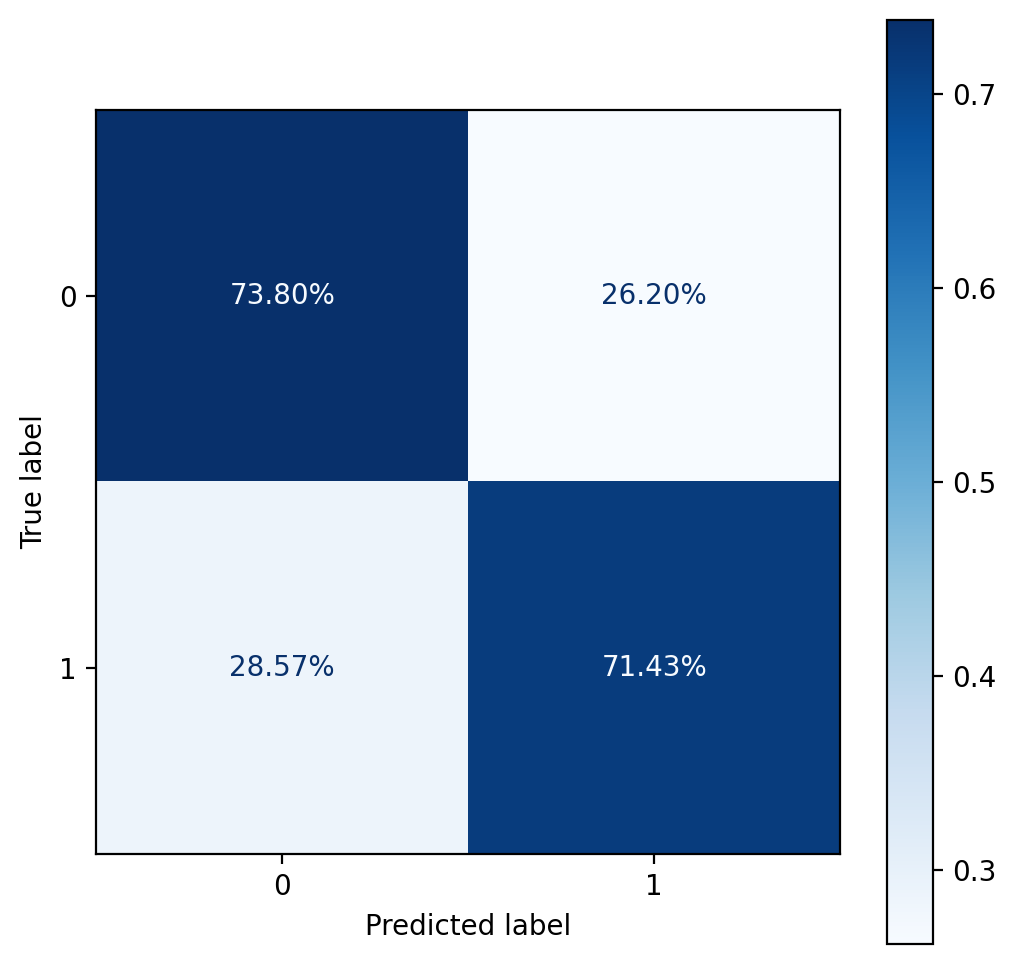

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 假设有真实标签y_true和预测标签y_pred
confusion_matrix = confusion_matrix(y, clustering.labels_, normalize="true")
# 设置图形大小和dpi
fig, ax = plt.subplots(figsize=(6, 6), dpi=200)
# 绘制混淆矩阵并显示百分比
display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
display.plot(
    include_values=True,
    cmap="Blues",
    ax=ax,
    xticks_rotation="horizontal",
    values_format=".2%",
)
plt.savefig(
    "./confusion matrix.png",
    format="png",
    facecolor="white",
    bbox_inches="tight",
)

# Problem 2

## 导入包

In [6]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## 读取并处理数据

In [7]:
# 读取数据
df = pd.read_csv('./heart_500.csv')
# 随机选取一半的样本作为训练集，另一半作为测试集
train_df, test_df = train_test_split(df, test_size=0.5, random_state=0)
# 记录 test_df 的索引
test_index = test_df.index
# 分离特征数据和标签数据
X_train = train_df.iloc[:, 1:].values
y_train = train_df.iloc[:, 0].values
X_test = test_df.iloc[:, 1:].values
y_test = test_df.iloc[:, 0].values
# 创建标准化器对象
scaler = StandardScaler()
# 对训练集中的特征数据进行标准化处理
X_train = scaler.fit_transform(X_train)
# 对测试集中的特征数据进行标准化处理
X_test = scaler.transform(X_test)

## 定义 conformal prediction 函数

In [8]:
def get_nonconformity_scores(X_train, y_train, new_x, new_y):
    x = np.concatenate((X_train, new_x.reshape(1, -1)), axis=0)
    y = np.concatenate((y_train, new_y.reshape(1)), axis=0)
    # 计算 x 之间的距离矩阵
    distance = cdist(x, x, "euclidean")
    # 将对角线元素设为无穷大
    np.fill_diagonal(distance, np.inf)
    # 计算相同标签的最小距离和不同标签的最小距离的比值，作为 nonconformity score
    nonconformity_scores = []
    for i in range(x.shape[0]):
        # 找到第 i 行中，与样本 i 标签相同的所有样本，并求其距离的最小值
        min_distance_with_same_label = np.min(distance[i, y == y[i]])
        # 找到第 i 行中，与样本 i 标签不同的所有样本，并求其距离的最小值
        min_distance_with_different_label = np.min(distance[i, y != y[i]])
        # 计算第 i 行的 nonconformity score
        nonconformity_score = min_distance_with_same_label / (
            min_distance_with_different_label + 0.001
        )
        nonconformity_scores.append(nonconformity_score)
    return nonconformity_scores


def get_prediction_set(X_train, y_train, new_x, level):
    # 遍历所有可能的标签值，计算新样本在该标签下的 p value
    p_values = []
    labels = list(set(y_train))
    for label in labels:
        # 计算训练样本的 nonconformity scores
        nonconformity_scores = get_nonconformity_scores(X_train, y_train, new_x, label)
        # 计算新样本的 nonconformity score 在训练样本中的排名
        rank = sum(nonconformity_scores >= nonconformity_scores[-1])
        # 计算 p value
        p_value = rank / len(nonconformity_scores)
        p_values.append(p_value)
    # 找到 p value 大于 1 - level 的标签
    prediction_set = [
        labels[i] if p_values[i] > 1 - level else None for i in range(len(p_values))
    ]
    # 去掉 None
    prediction_set = [i for i in prediction_set if i is not None]
    return prediction_set

## 在测试集上进行 conformal prediction

### 与真实标签进行比较，考察 prediction set 的覆盖率

In [9]:
level = 0.9
count = 0
prediction_sets = []
for i in range(X_test.shape[0]):
    prediction_set = get_prediction_set(X_train, y_train, X_test[i], level)
    prediction_sets.append(prediction_set)
    if y_test[i] in prediction_set:
        count += 1
correct_rate = count / X_test.shape[0]
print("level: {:.2%}, correct rate: {:.2%}".format(level, correct_rate))

level: 90.00%, correct rate: 86.40%


与真实标签进行比较时，prediction set 的覆盖率与 $90\%$ 较接近。

### 与 Problem 1 中的聚类结果进行比较，考察 prediction set 的覆盖率

In [10]:
level = 0.9
count = 0
prediction_sets = []
for i in range(X_test.shape[0]):
    prediction_set = get_prediction_set(X_train, y_train, X_test[i], level)
    prediction_sets.append(prediction_set)
    if clustering.labels_[i] in prediction_set:
        count += 1
correct_rate = count / X_test.shape[0]
print("level: {:.2%}, correct rate: {:.2%}".format(level, correct_rate))

level: 90.00%, correct rate: 68.40%


与 Problem 1 中的聚类结果进行比较时，prediction set 的覆盖率为 $68.4\%$，低于 $90\%$。

# Problem 3

## 导入包

In [11]:
import numpy as np
import scipy.stats as stats
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from rich.progress import Progress
plt.rcParams["axes.unicode_minus"] = False
# 设置随机数种子
np.random.seed(0)

## 定义 Laws 类

In [12]:
class Laws:
    def __init__(
        self,
        alpha=0.05,
        pai_list=[0.9, 0.6],
        mu=2.5,
        tau=0.4,
    ):
        """
        Args:
            alpha: float, 0 < alpha < 1，FDR 控制水平
            pai_list: list, 每个 block 的 pai，长度为 2
            mu: float, 每个 block 的 mu
            tau: float, 0 < tau < 1，screening procedure 的阈值
        """
        self.alpha = alpha
        self.pai_list = pai_list
        self.mu = mu
        self.tau = tau
        # 生成 pai
        self.pai = self.generate_pai()
        # 生成 theta，theta 来自参数为 pai 的伯努利分布
        self.theta = np.random.binomial(1, self.pai, 5000)
        # 生成 x，x 由标准正态分布和均值为 mu 的正态分布混合而成，混合比例为 theta
        self.x = np.random.normal(self.theta * self.mu, 1)
        # 计算 x 在原假设下的 p 值
        self.p_value = (1 - stats.norm.cdf(abs(self.x))) * 2
        # 生成 v_h
        self.v_h = self.generate_v_h()
        # 计算 pai_hat
        self.pai_hat = self.get_pai_hat()
        # 计算加权后的 p value
        self.weighted_p_value = self.get_weighted_p_value()
        # 计算拒绝域的 p value 阈值
        self.reject_threshold = self.get_reject_threshold()

    def generate_pai(self):
        """
        生成 pai
        """
        # 生成 5000 个 pai
        # 其他的 pai 为 0.01
        pai = np.ones(5000) * 0.01
        # [1001, 1200] 和 [2001, 2200] 之间的 pai 为 self.pai_list[0]
        pai[1000:1199] = self.pai_list[0]
        pai[2000:2199] = self.pai_list[0]
        # [3001, 3200] 和 [4001, 4200] 之间的 pai 为 self.pai_list[1]
        pai[3000:3199] = self.pai_list[1]
        pai[4000:4199] = self.pai_list[1]
        return pai

    def generate_v_h(self):
        """
        生成 v_h
        """
        # 生成 5000 个 s
        s = np.arange(5000).reshape(-1, 1)
        # 计算每个 s 之间欧式距离
        dist = cdist(s, s)
        # 设置带宽
        h = 40
        # 对 dist 应用高斯核函数，得到 k_h
        k_h = stats.norm.pdf(dist / h, loc=0, scale=1) / h
        # 将 k_h 除以 k_h(0)，得到 v_h
        k_h_0 = stats.norm.pdf(0, loc=0, scale=1) / h
        v_h = k_h / k_h_0
        return v_h

    def get_pai_hat(self):
        """
        计算 pai_hat
        """
        # 筛选出 p value 大于 tau 的样本
        subset = self.p_value > self.tau
        # 根据 equation 4.5 计算 pai_hat
        pai_hat = 1 - (
            np.sum(self.v_h[:, subset], axis=1)
            / ((1 - self.tau) * np.sum(self.v_h, axis=1))
        )
        # 取 v = 1e-5，将 pai_hat 限制在 [v, 1-v] 之间
        v = 1e-5
        pai_hat = np.clip(pai_hat, v, 1 - v)
        return pai_hat

    def get_weighted_p_value(self):
        """
        计算加权后的 p value
        """
        # 计算权重
        weight = self.pai_hat / (1 - self.pai_hat)
        # 计算加权后的 p value
        weighted_p_value = np.minimum(self.p_value / weight, 1)
        return weighted_p_value

    def get_reject_threshold(self):
        """
        计算拒绝域的 p value 阈值
        """
        # 将 p value 从小到大排序，得到排序后的索引
        sorted_index = np.argsort(self.weighted_p_value)
        # 找到第一个 p value 大于 alpha * i / 5000 的索引
        for j in range(5000):
            fdp = (
                np.sum(self.pai_hat) * self.weighted_p_value[sorted_index[j]] / (j + 1)
            )
            if fdp > self.alpha:
                break
        # 返回拒绝域的 p value 阈值
        return self.weighted_p_value[sorted_index[j - 1]]

    def get_fdp(self):
        """
        计算错误拒绝率
        """
        # 每个样本是否被拒绝
        reject_or_not = self.weighted_p_value < self.reject_threshold
        # 计算错误拒绝的假设的个数
        num_false_reject = np.sum(reject_or_not * (1 - self.theta))
        # 计算拒绝的假设的总数
        num_reject = np.sum(reject_or_not)
        # 返回错误拒绝率
        return num_false_reject / num_reject
    
    def get_power(self):
        """
        计算 power
        """
        # 每个样本是否被拒绝
        reject_or_not = self.weighted_p_value < self.reject_threshold
        # 计算正确拒绝的假设的个数
        num_true_reject = np.sum(reject_or_not * self.theta)
        # 计算应该被拒绝的假设的总数
        num_should_reject = np.sum(self.theta)
        # 返回错误拒绝率
        return num_true_reject / num_should_reject

## 定义绘图函数

In [20]:
def plot(x_list, y_list, type, mode):
    # 设置画布大小
    fig = plt.figure(figsize=(10, 5), dpi=200)
    plt.plot(x_list, y_list, marker="D", label="LAWS.DD")
    # 添加 x 轴刻度、xy 轴标签和标题
    if type == "mu":
        plt.xticks(np.arange(2, 4.2, 0.5))
        plt.xlabel(r"$\mu$")
    if type == "pai":
        plt.xticks(np.arange(0.4, 1, 0.1))
        plt.xlabel(r"$\pi$")
    if mode == "fdr":
        plt.ylim(0.0, 0.102)
        plt.ylabel("FDR")
        plt.title("FDR Comparison")
        # 显示图例
        plt.legend(loc="upper right")
    if mode == "power":
        plt.ylim(0.0, 1.02)
        plt.ylabel("Power")
        plt.title("Power Comparison")
        # 显示图例
        plt.legend(loc="lower right")
    # 显示图片
    plt.show()
    # 保存图片
    fig.savefig(
        f"./{type}_{mode}.png",
        format="png",
        facecolor="white",
        bbox_inches="tight",
    )

## 数值试验

考察不同的 mu

In [ ]:
mu_list = np.linspace(2, 4, 11)
with Progress() as progress:
    task1 = progress.add_task("[green]Iterating mu list...", total=11)
    fdp_list_mu = []
    power_list_mu = []
    for mu in mu_list:
        # 重复 200 次，计算 fdp 和 power 的均值
        task2 = progress.add_task("[cyan]Doing 200 replications...", total=200)
        fdp_sum = 0
        power_sum = 0
        for _ in range(200):
            fdp_sum += Laws(mu=mu).get_fdp()
            power_sum += Laws(mu=mu).get_power()
            progress.update(task2, advance=1)
        progress.remove_task(task2)
        fdp = fdp_sum / 200
        fdp_list_mu.append(fdp)
        power = power_sum / 200
        power_list_mu.append(power)
        progress.update(task1, advance=1)
    progress.remove_task(task1)

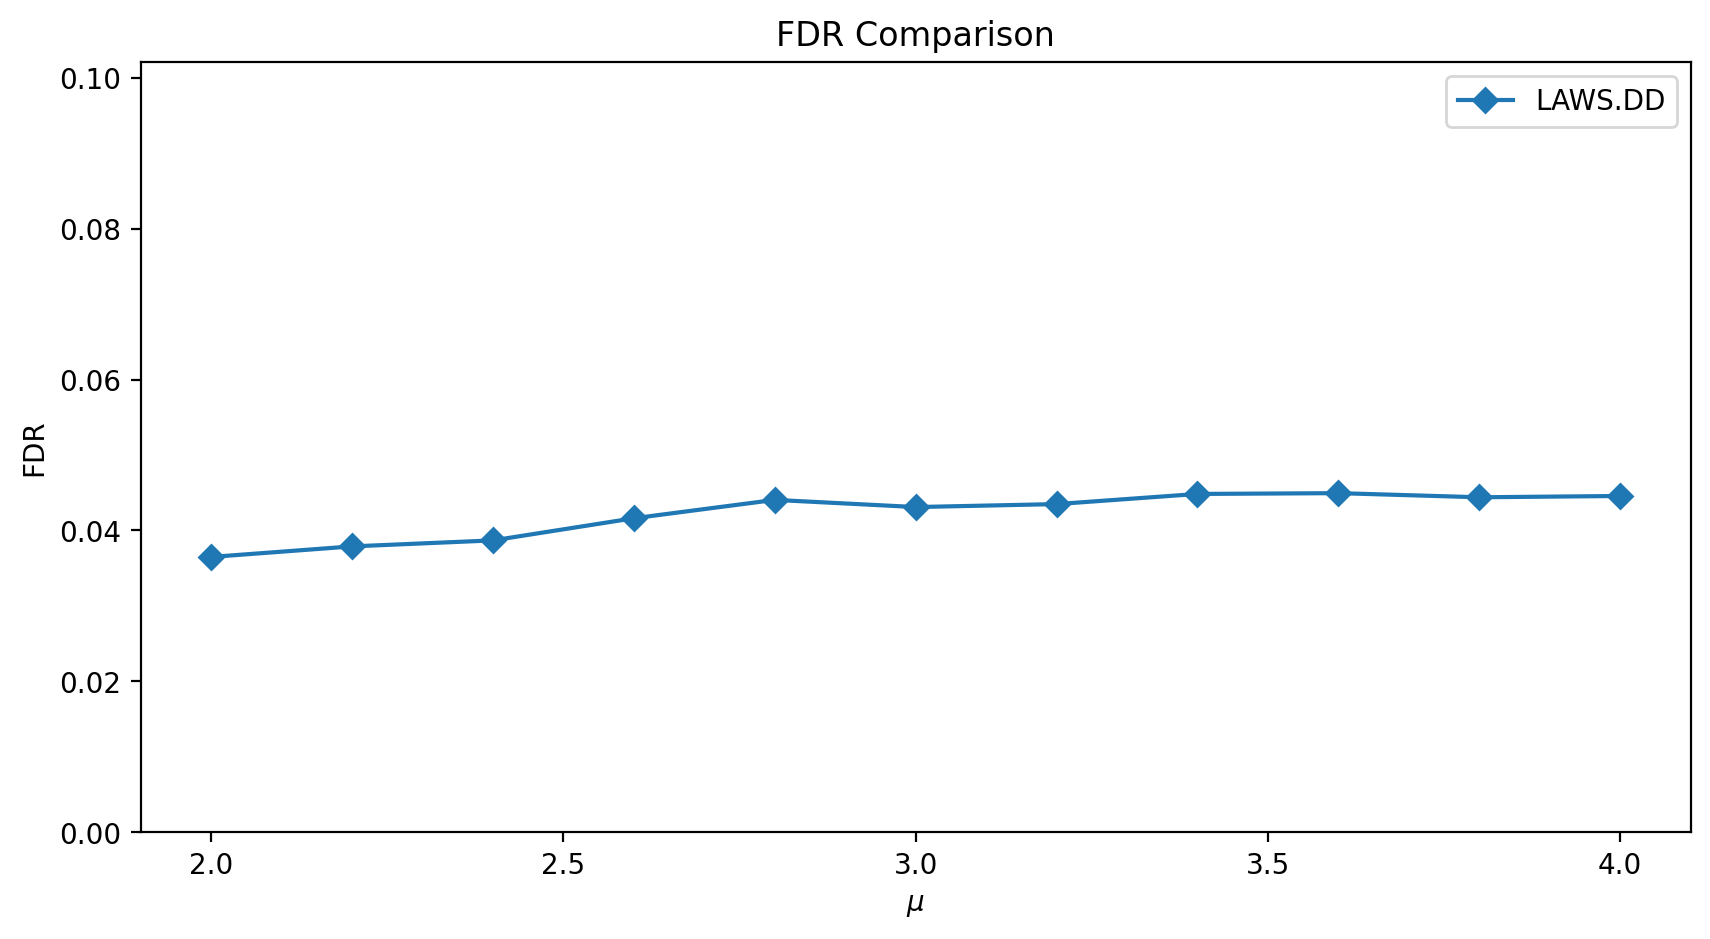

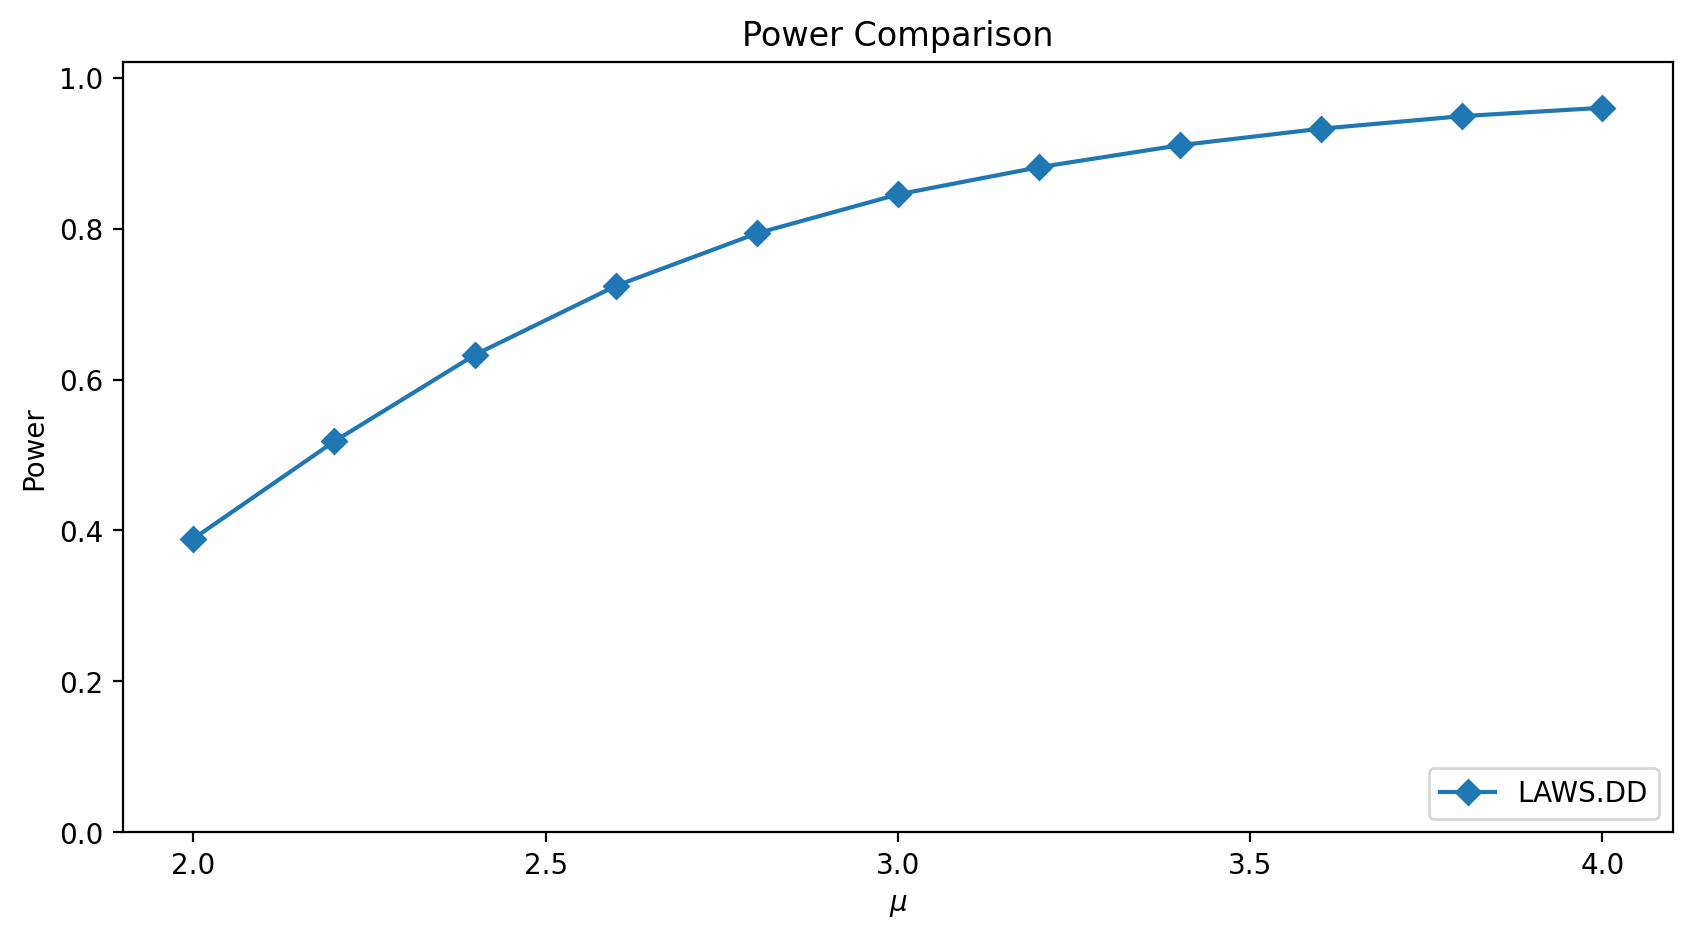

In [22]:
# 绘制不同 mu 下的 fdp
plot(mu_list, fdp_list_mu, "mu", "fdr")
# 绘制不同 mu 下的 power
plot(mu_list, power_list_mu, "mu", "power")

考察不同的 pai

In [ ]:
pai_list = np.linspace(0.36, 0.9, 10)
with Progress() as progress:
    task1 = progress.add_task("[green]Iterating pai list...", total=10)
    fdp_list_pai = []
    power_list_pai = []
    for pai in pai_list:
        # 重复 200 次，计算 fdp 的均值
        task2 = progress.add_task("[cyan]Doing 200 replications...", total=200)
        fdp_sum = 0
        power_sum = 0
        for _ in range(200):
            fdp_sum += Laws(pai_list=[pai, pai]).get_fdp()
            power_sum += Laws(pai_list=[pai, pai]).get_power()
            progress.update(task2, advance=1)
        progress.remove_task(task2)
        fdp = fdp_sum / 200
        fdp_list_pai.append(fdp)
        power = power_sum / 200
        power_list_pai.append(power)
        progress.update(task1, advance=1)
    progress.remove_task(task1)

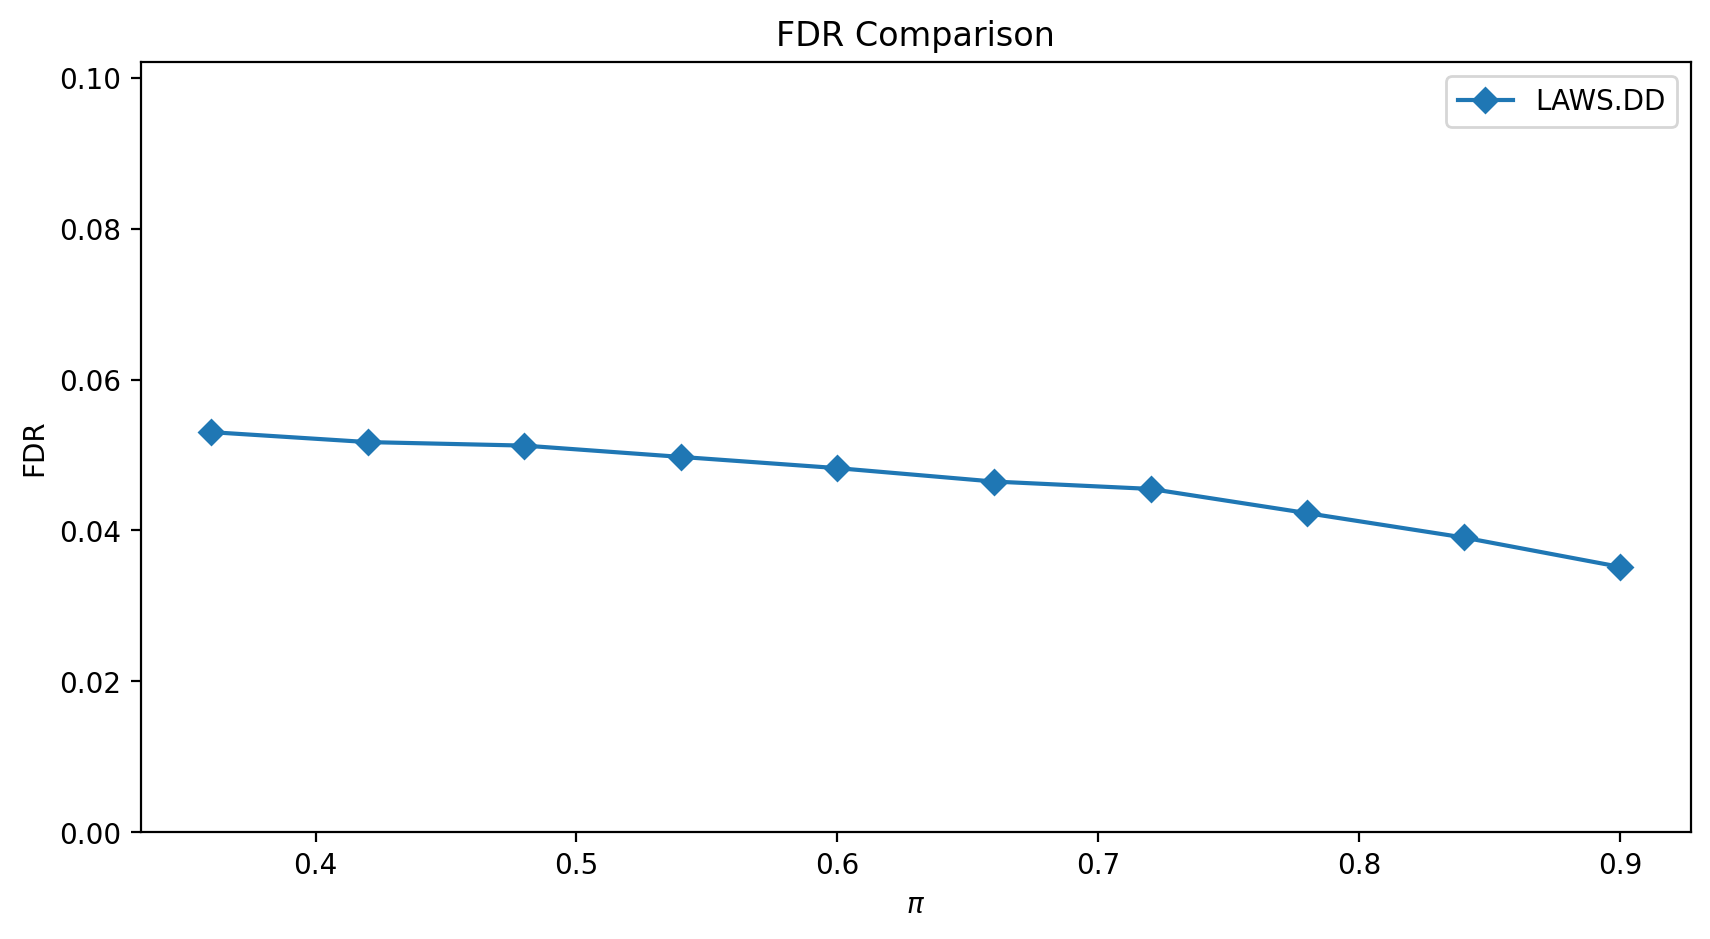

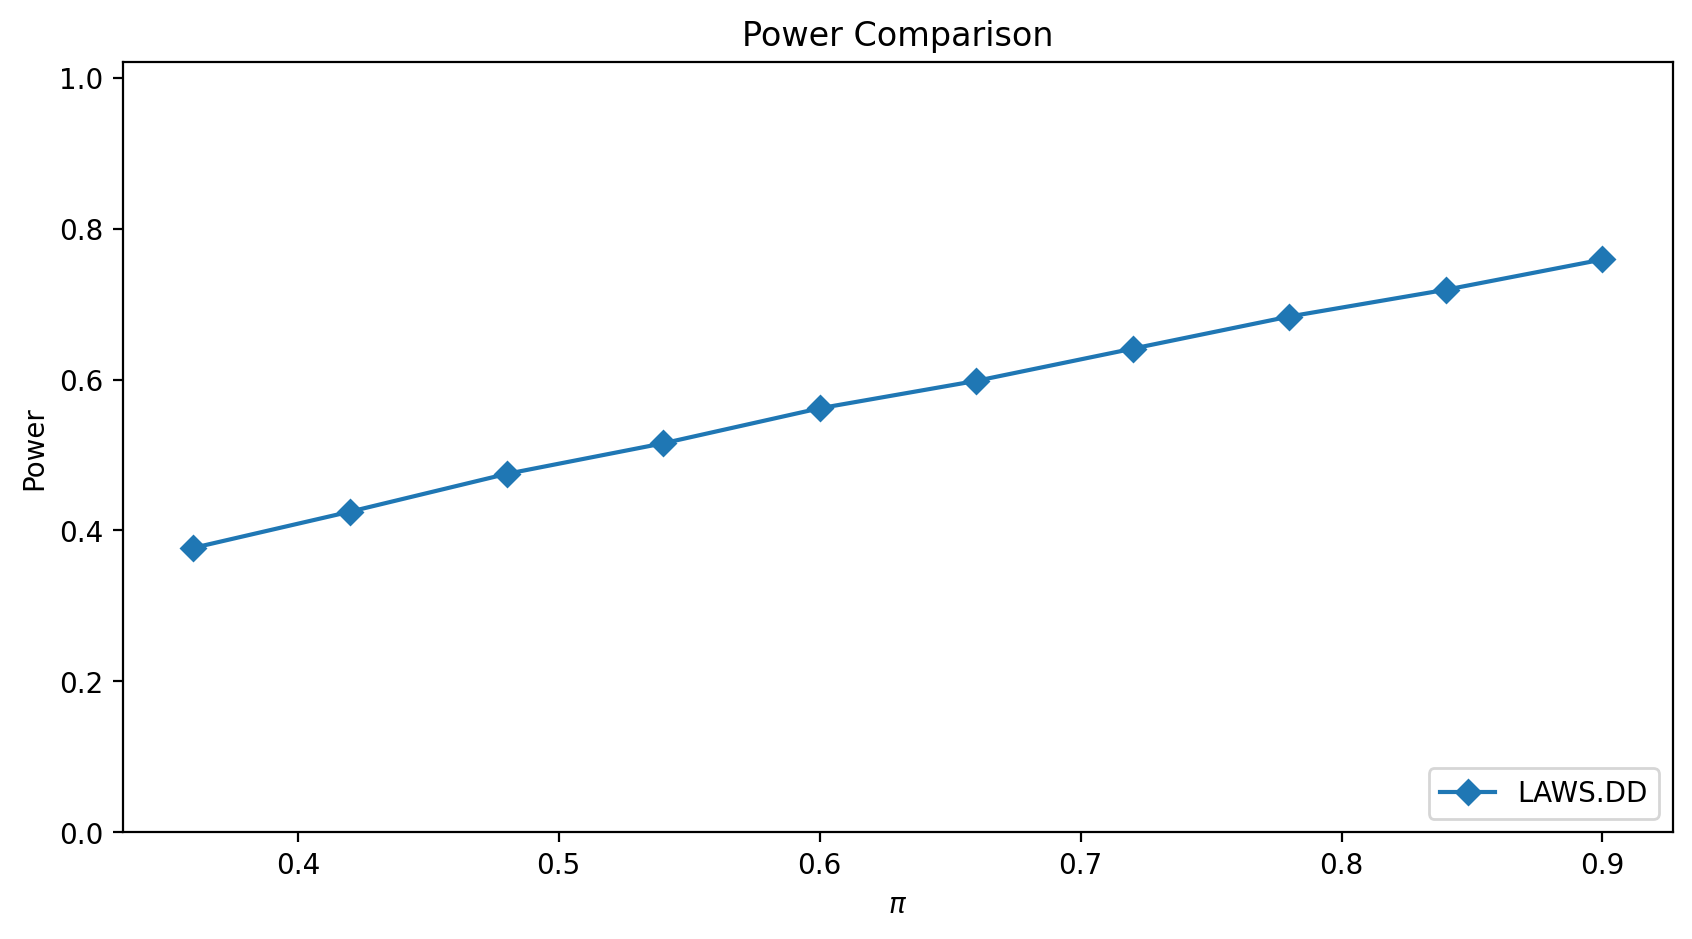

In [23]:
# 绘制不同 pai 下的 fdp
plot(pai_list, fdp_list_pai, 'pai', 'fdr')
# 绘制不同 pai 下的 power
plot(pai_list, power_list_pai, 'pai', 'power')